# Top-N predictions

## Data and tools import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.append('../src/')
from io_work import stringSplitByNumbers


## Load common data

In [2]:
data_dirname = '../data/'
label_plant_filename = 'species.csv'
label_plant_dict = pd.read_csv(data_dirname+label_plant_filename, index_col=0)
label_plant_dict = label_plant_dict.to_dict()['Species name']
label_plant_dict[-1] = 'Negative class'
print label_plant_dict

{1: 'Althaea officinalis', 2: 'Aronia melanocarpa', 3: 'Bergenia crassifolia', 4: 'Betula pendula (leaves)', 5: 'Betula pendula (buds)', 6: 'Helichrysum arenarium', 7: 'Sambucus nigra (flowers)', 8: 'Valeriana officinalis', 9: 'Ginkgo biloba', 10: 'Melilotus officinalis', 11: 'Origanum vulgare', 12: 'Panax ginseng', 13: 'Rhamnus cathartica', 14: 'Fragaria vesca', 15: 'Hypericum perforatum', 16: 'Viburnum opulus', 17: 'Coriandrum sativum', 18: 'Urtica dioica', 20: 'Frangula alnus', 23: 'Convallaria transcaucasica', 24: 'Potentilla erecta', 25: 'Tilia cordata', 26: 'Linum usitatissimum', 27: 'Arctium lappa', 28: 'Tussilago farfara', 29: 'Juniperus communis', 30: 'Mentha x piperita', 31: 'Calendula officinalis', 32: 'Tanacetum vulgare', 33: 'Plantago major', 34: 'Artemisia absinthium', 35: 'Leonurus quinquelobatus', 36: 'Silybum marianum', 37: 'Rhodiola rosea', 38: 'Matricaria chamomilla', 39: 'Senna alexandrina', 40: 'Polemonium caeruleum', 41: 'Glycyrrhiza glabra', 42: 'Pinus sylvestris

## Functions for visualization

In [3]:
def savePlotedCustomConfusionMatrix(
        custom_confusion_matrix, labels, filename, figsize=(20, 20),
        extension='pdf', show=True, mask=None
):
    df_cm = pd.DataFrame(
        custom_confusion_matrix,
        index=labels,
        columns=labels
    )
    
    if mask is None:
        mask = np.ones(custom_confusion_matrix.shape)
        np.fill_diagonal(mask, 0.)

    plt.clf()
    plt.figure(figsize=figsize)
    vmin=np.min(mask*custom_confusion_matrix)
    vmax=np.max(mask*custom_confusion_matrix)
    sns.heatmap(
        df_cm, annot=True, cbar=0,
        vmin=vmin, vmax=vmax,
        cmap="afmhot", fmt='.1f'
    )
    plt.savefig(filename+'.'+extension)
    if show:
        plt.show()

## Functions to perform analysis of the results

In [4]:
def funcTopN(prediction_matrix, classes, N=5):
    placesDict = {}
    topsDict = {}
    for i_lab in xrange(len(classes)):
        current_class = classes[i_lab]
        ind = np.where(prediction_matrix[:, -1] == current_class)[0]
        sorted_pred_ind = np.argsort(prediction_matrix[ind, :-1], axis=1)[:, ::-1]
        place_true_class = []
        topN_local = []
        for i_samp in xrange(len(ind)):
            tmp = np.argmax(classes[sorted_pred_ind[i_samp]] == current_class)
            place_true_class.append( tmp+1 )
            topN_local.append(classes[sorted_pred_ind[i_samp]][:N])
        placesDict[current_class] = place_true_class
        topsDict[current_class] = topN_local
    return placesDict, topsDict

def getAccuracyTopN(prediction_matrices, classes, N, only_accuracies=False):
    Ntrials = len(prediction_matrices)
    #pdicts = []
    #tdicts = []
    tops = {element: {} for element in classes}
    accuracies = []
    for k_tr in xrange(Ntrials):
        pdict, tdict = funcTopN(prediction_matrices[k_tr], classes, N)
        #pdicts.append( pdict )
        #tdicts.append( tdict )
        #for k in xrange(25):
        #pdict = pdicts[k]
        #tdict = tdicts[k]
        loc_accuracies = []
        for n in xrange(N):
            length = 0
            tmp = 0
            for key in pdict.keys():
                tmp += np.sum(np.array(pdict[key]) <= n+1)
                length += len(pdict[key])
            accuracy = float(tmp) / length
            loc_accuracies.append( accuracy )
        accuracies.append( loc_accuracies )
        if not only_accuracies:
            for key in tdict.keys():
                #loc_top = {}
                set_pred, set_counts = np.unique(reduce(lambda x, y: list(x)+list(y), tdict[key]), return_counts=True)
                set_counts = set_counts / float(len(tdict[key]))
                ind = np.argsort(set_counts)[::-1]
                set_pred, set_counts = set_pred[ind[:N]], set_counts[ind[:N]]
                local_keys = tops[key].keys()
                for i_loc in xrange(N):
                    local_key = set_pred[i_loc]
                    if local_key in local_keys:
                        tops[key][local_key] += set_counts[i_loc]
                    else:
                        tops[key][local_key] = set_counts[i_loc]
    accuracies = np.median(accuracies, axis=0)
    if only_accuracies:
        return accuracies
    final_tops = {}
    for key in tops.keys():
        for key_loc in tops[key].keys():
            tops[key][key_loc] /= Ntrials
        #sorted_keys = sorted(tops[key].items(), key=operator.itemgetter(0))
        sorted_keys = sorted(tops[key].items(), key=lambda (k,v): (v,k))
        final_tops[key] = sorted_keys[::-1][:N]
    return accuracies, final_tops

## Autoencoder + Logistic Regression

In [5]:
df_lr = np.load('../results/autoencoder+LR.npz')
prediction_matrices_test1 = df_lr['predicted_probas_test']
prediction_matrices_test2 = df_lr['predicted_probas_test2']
classes = np.unique(prediction_matrices_test1[0][:, -1]) # it contains all necessary classes

N = 5
accuracies_test1, final_tops_test1 = getAccuracyTopN(prediction_matrices_test1, classes, N)
accuracies_test1 = ['test1'] + list(accuracies_test1)
accuracies_test2 = getAccuracyTopN(prediction_matrices_test2, classes, N, only_accuracies=True)
accuracies_test2 = ['test2'] + list(accuracies_test2)
accuracies = [accuracies_test1, accuracies_test2]
df = pd.DataFrame(accuracies, columns=['part']+['top %d' % (i+1) for i in xrange(N)])
df.set_index('part', inplace=True)
print 'accuracy (AE+LR) top %d' % (N)
df

accuracy (AE+LR) top 5


,top 1,top 2,top 3,top 4,top 5
part,,,,,
test1,0.831858,0.915888,0.943925,0.954887,0.969925
test2,0.727273,0.795455,0.818182,0.863636,0.863636


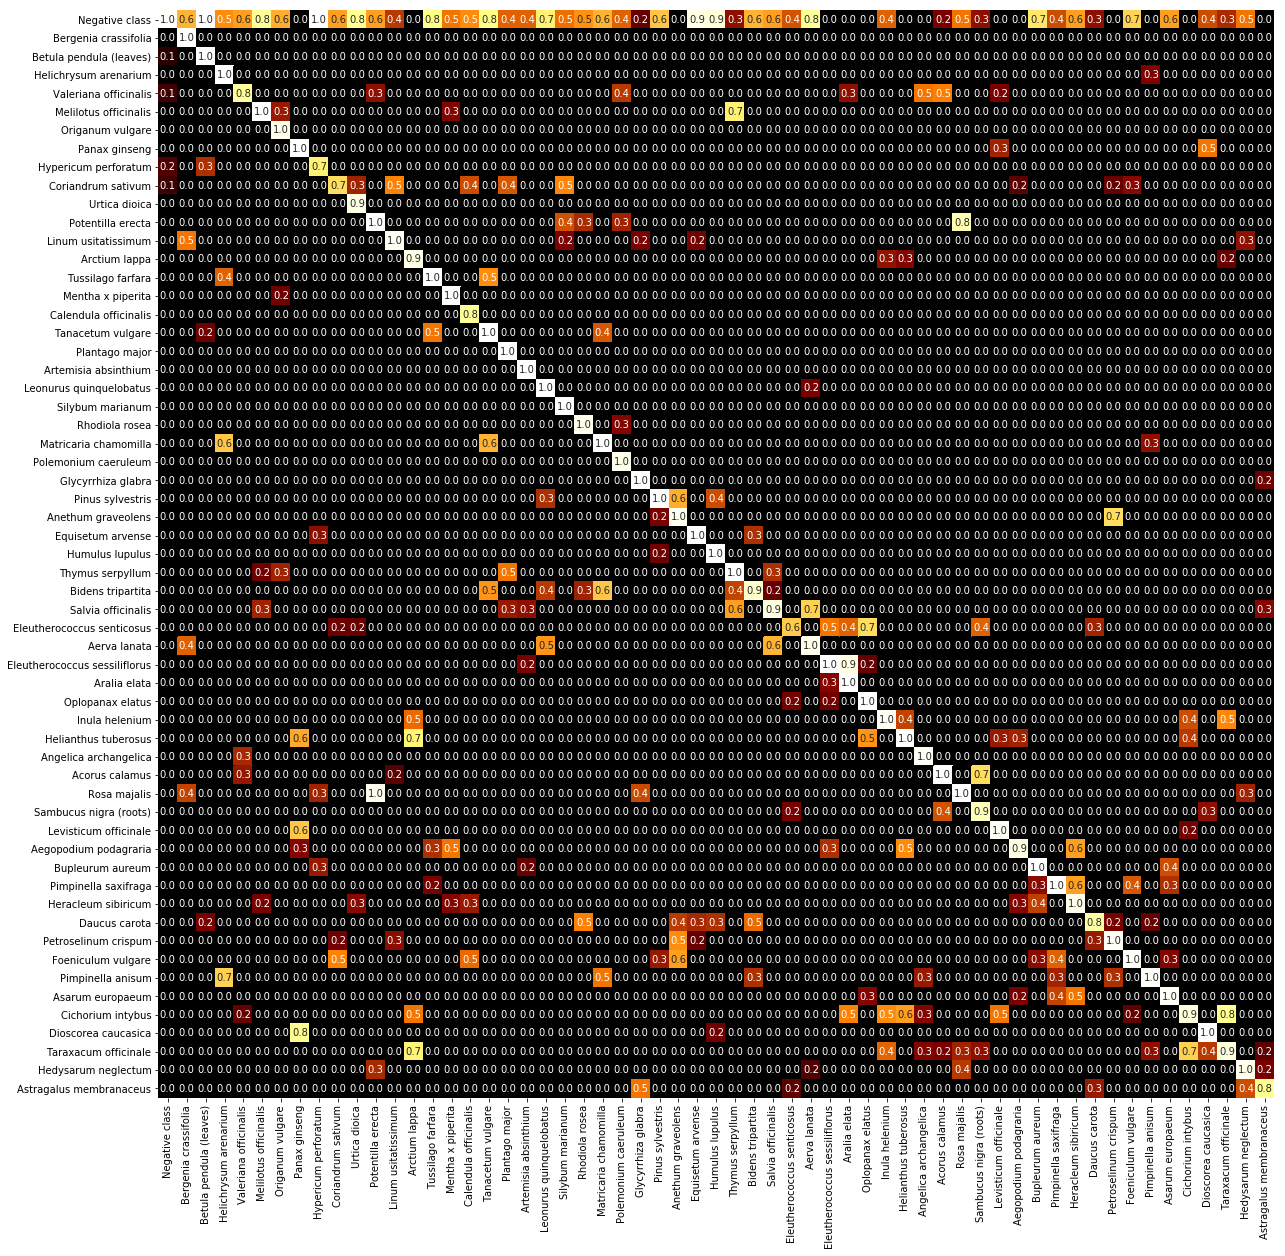

In [6]:
Nclasses = len(classes)
df_mat = np.zeros([Nclasses, Nclasses])
#mask = np.zeros([Nclasses, Nclasses])
#mask += np.nan
for i_act in xrange(Nclasses):
    current_class = classes[i_act]
    current_top = final_tops_test1[current_class]
    for (pred_class, freq) in current_top:
        j_pred = np.where(classes == pred_class)[0]
        df_mat[j_pred, i_act] = freq
        #if j_pred != i_act:
        #    mask[j_pred, i_act] = 1
        #else:
        #    mask[j_pred, i_act] = 0
filename = 'ae+lr_top5'
df_labels = map(lambda x: label_plant_dict[x], classes)
savePlotedCustomConfusionMatrix(
        df_mat, df_labels, filename, figsize=(20, 20),
        extension='pdf', show=True
)

Each column represents true label; predicted labels are depicted as rows. In each column frequency of occuring of each top-5 prediction is placed.

## Autoencoder + Naive Bayes

In [7]:
df_nb = np.load('../results/autoencoder+NB.npz')
prediction_matrices_test1 = df_nb['predicted_probas_test']
prediction_matrices_test2 = df_nb['predicted_probas_test2']
classes = np.unique(prediction_matrices_test1[0][:, -1]) # it contains all necessary classes

N = 5
accuracies_test1, final_tops_test1 = getAccuracyTopN(prediction_matrices_test1, classes, N)
accuracies_test1 = ['test1'] + list(accuracies_test1)
accuracies_test2 = getAccuracyTopN(prediction_matrices_test2, classes, N, only_accuracies=True)
accuracies_test2 = ['test2'] + list(accuracies_test2)
accuracies = [accuracies_test1, accuracies_test2]
df = pd.DataFrame(accuracies, columns=['part']+['top %d' % (i+1) for i in xrange(N)])
df.set_index('part', inplace=True)
print 'accuracy (AE+NB) top %d' % (N)
df

accuracy (AE+NB) top 5


,top 1,top 2,top 3,top 4,top 5
part,,,,,
test1,0.672897,0.785047,0.827068,0.849624,0.882759
test2,0.727273,0.795455,0.863636,0.886364,0.886364


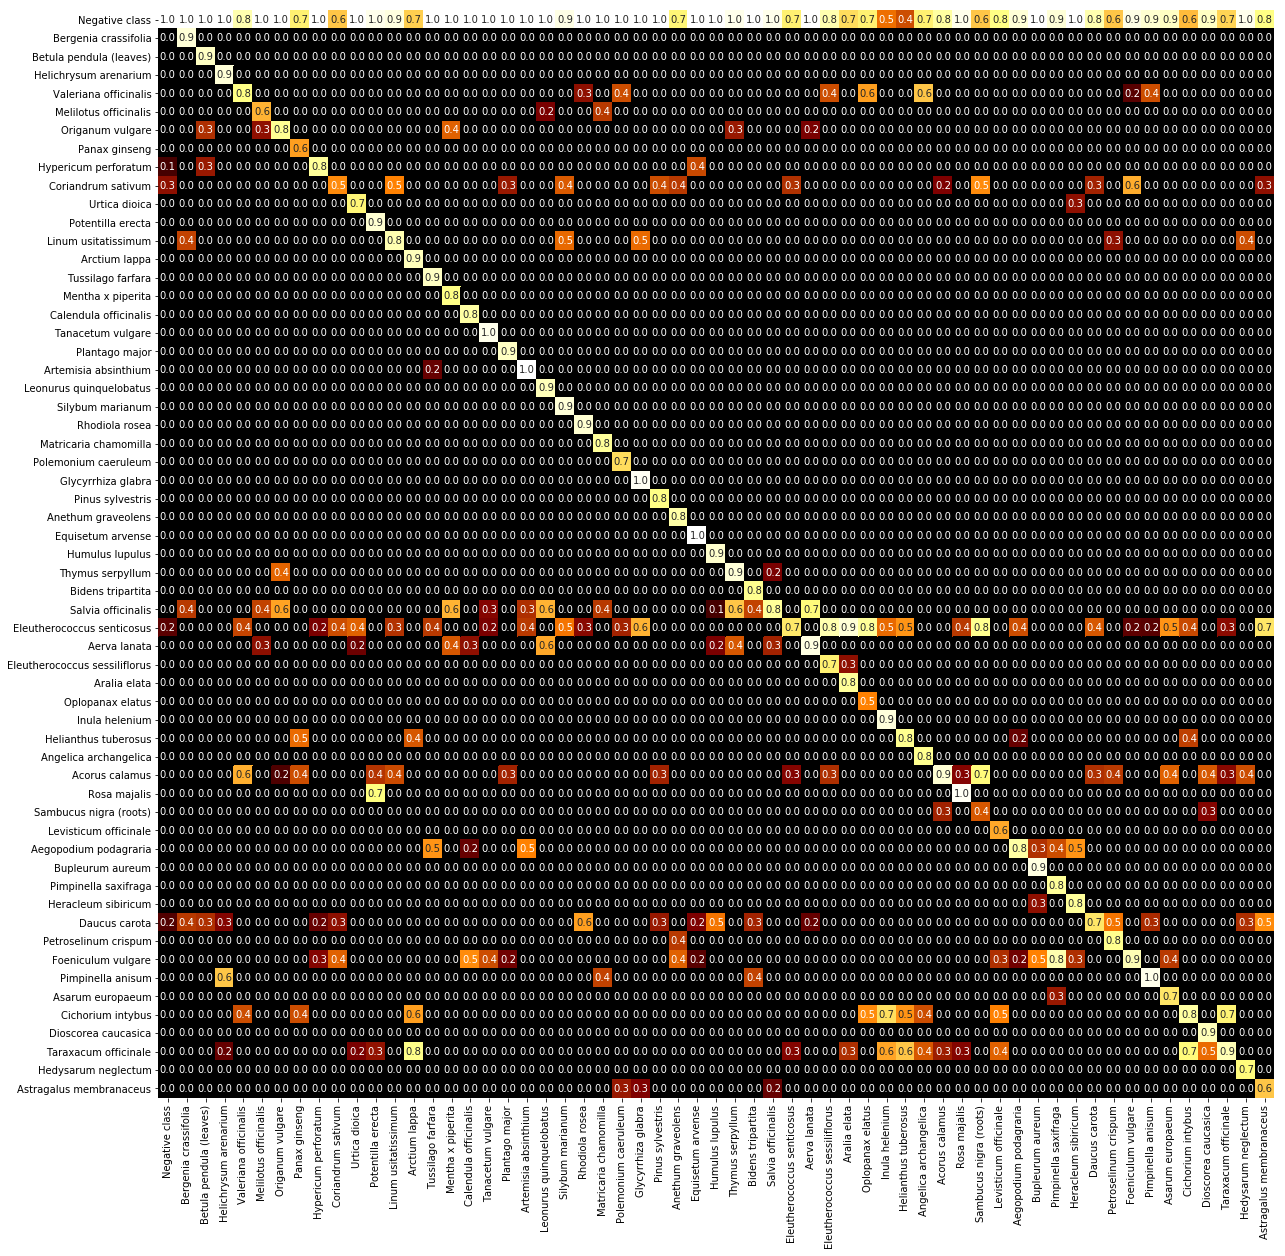

In [8]:
Nclasses = len(classes)
df_mat = np.zeros([Nclasses, Nclasses])
for i_act in xrange(Nclasses):
    current_class = classes[i_act]
    current_top = final_tops_test1[current_class]
    for (pred_class, freq) in current_top:
        j_pred = np.where(classes == pred_class)[0]
        df_mat[j_pred, i_act] = freq
filename = 'ae+nb_top5'
df_labels = map(lambda x: label_plant_dict[x], classes)
savePlotedCustomConfusionMatrix(
        df_mat, df_labels, filename, figsize=(20, 20),
        extension='pdf', show=True
)

## Large Bayesian Networks (with binarized features)

In [9]:
results_filename_prefix = 'validation_results_on_model_'
results_dirname = '../results/large_bayesian_networks/'
filename_dataset1 = 'bn_dataset.csv'
filename_dataset2 = 'bn_test2.csv'


all_result_filenames = os.listdir(results_dirname)
all_result_filenames = filter(lambda x: x.startswith(results_filename_prefix), all_result_filenames)
all_result_filenames = filter(lambda x: x.endswith('.csv'), all_result_filenames)
all_result_filenames = sorted(all_result_filenames, key=stringSplitByNumbers)

all_result_filenames_test1 = filter(lambda x: filename_dataset1 in x, all_result_filenames)
all_result_filenames_test2 = filter(lambda x: filename_dataset2 in x, all_result_filenames)

prediction_matrices_test1 = []
prediction_matrices_test2 = []
for i in range(len(all_result_filenames_test1)):
    df = pd.read_csv(results_dirname+all_result_filenames_test1[i], index_col=0)
    prediction_matrices_test1.append(df.values)
    df = pd.read_csv(results_dirname+all_result_filenames_test2[i], index_col=0)
    prediction_matrices_test2.append(df.values)
    '''
    labels = list(map(float, df.columns.values[:-1]))
    labels = np.array(labels).astype('i')
    true_labels = df.iloc[:, -1].values
    predicted_labels = df.iloc[:, :-1].values
    ind = np.argmax(predicted_labels, axis=1)
    predicted_labels = labels[ind]
    current_accuracy = accuracy_score(true_labels, predicted_labels)
    current_f1score = f1_score(true_labels, predicted_labels, average='weighted')
    loc_accs.append(current_accuracy)
    loc_f1s.append(current_f1score)
    '''
classes = np.unique(prediction_matrices_test1[0][:, -1]) # it contains all necessary classes

N = 5
accuracies_test1, final_tops_test1 = getAccuracyTopN(prediction_matrices_test1, classes, N)
accuracies_test1 = ['test1'] + list(accuracies_test1)
accuracies_test2 = getAccuracyTopN(prediction_matrices_test2, classes, N, only_accuracies=True)
accuracies_test2 = ['test2'] + list(accuracies_test2)
accuracies = [accuracies_test1, accuracies_test2]
df = pd.DataFrame(accuracies, columns=['part']+['top %d' % (i+1) for i in xrange(N)])
df.set_index('part', inplace=True)
print 'accuracy (Large BN) top %d' % (N)
df

accuracy (Large BN) top 5


,top 1,top 2,top 3,top 4,top 5
part,,,,,
test1,0.793103,0.859813,0.876106,0.876623,0.882759
test2,0.750000,0.863636,0.886364,0.909091,0.909091


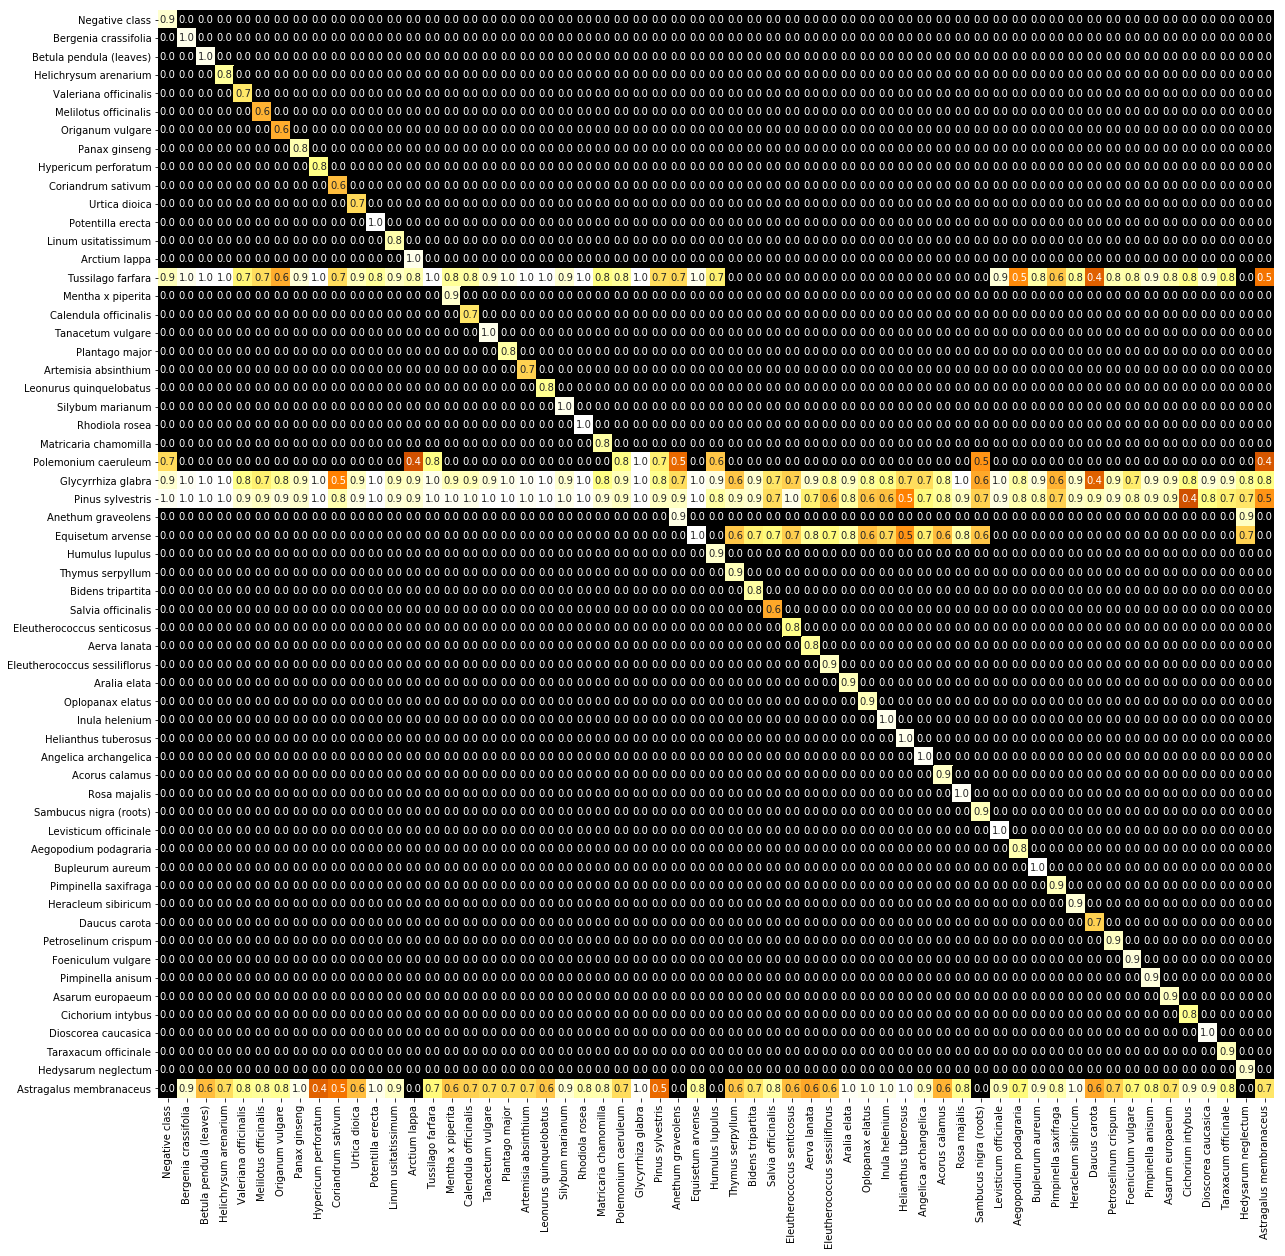

In [10]:
Nclasses = len(classes)
df_mat = np.zeros([Nclasses, Nclasses])
for i_act in xrange(Nclasses):
    current_class = classes[i_act]
    current_top = final_tops_test1[current_class]
    for (pred_class, freq) in current_top:
        j_pred = np.where(classes == pred_class)[0]
        df_mat[j_pred, i_act] = freq
filename = 'lbn_top5'
df_labels = map(lambda x: label_plant_dict[x], classes)
savePlotedCustomConfusionMatrix(
        df_mat, df_labels, filename, figsize=(20, 20),
        extension='pdf', show=True
)

## Sparse NMF 

In [11]:
df_nb = np.load('../results/rank=25model_md_snn_+CCA.npz')
prediction_matrices_test1 = df_nb['predicted_pa_test']
prediction_matrices_test2 = df_nb['predicted_pa_test2']
classes = np.unique(prediction_matrices_test1[0][:, -1]) # it contains all necessary classes

N = 5
accuracies_test1, final_tops_test1 = getAccuracyTopN(prediction_matrices_test1, classes, N)
accuracies_test1 = ['test1'] + list(accuracies_test1)
accuracies_test2 = getAccuracyTopN(prediction_matrices_test2, classes, N, only_accuracies=True)
accuracies_test2 = ['test2'] + list(accuracies_test2)
accuracies = [accuracies_test1, accuracies_test2]
df = pd.DataFrame(accuracies, columns=['part']+['top %d' % (i+1) for i in xrange(N)])
df.set_index('part', inplace=True)
print 'accuracy (SNMF) top %d' % (N)
df

accuracy (SNMF) top 5


,top 1,top 2,top 3,top 4,top 5
part,,,,,
test1,0.752212,0.796460,0.812030,0.827068,0.837662
test2,0.818182,0.840909,0.863636,0.863636,0.886364


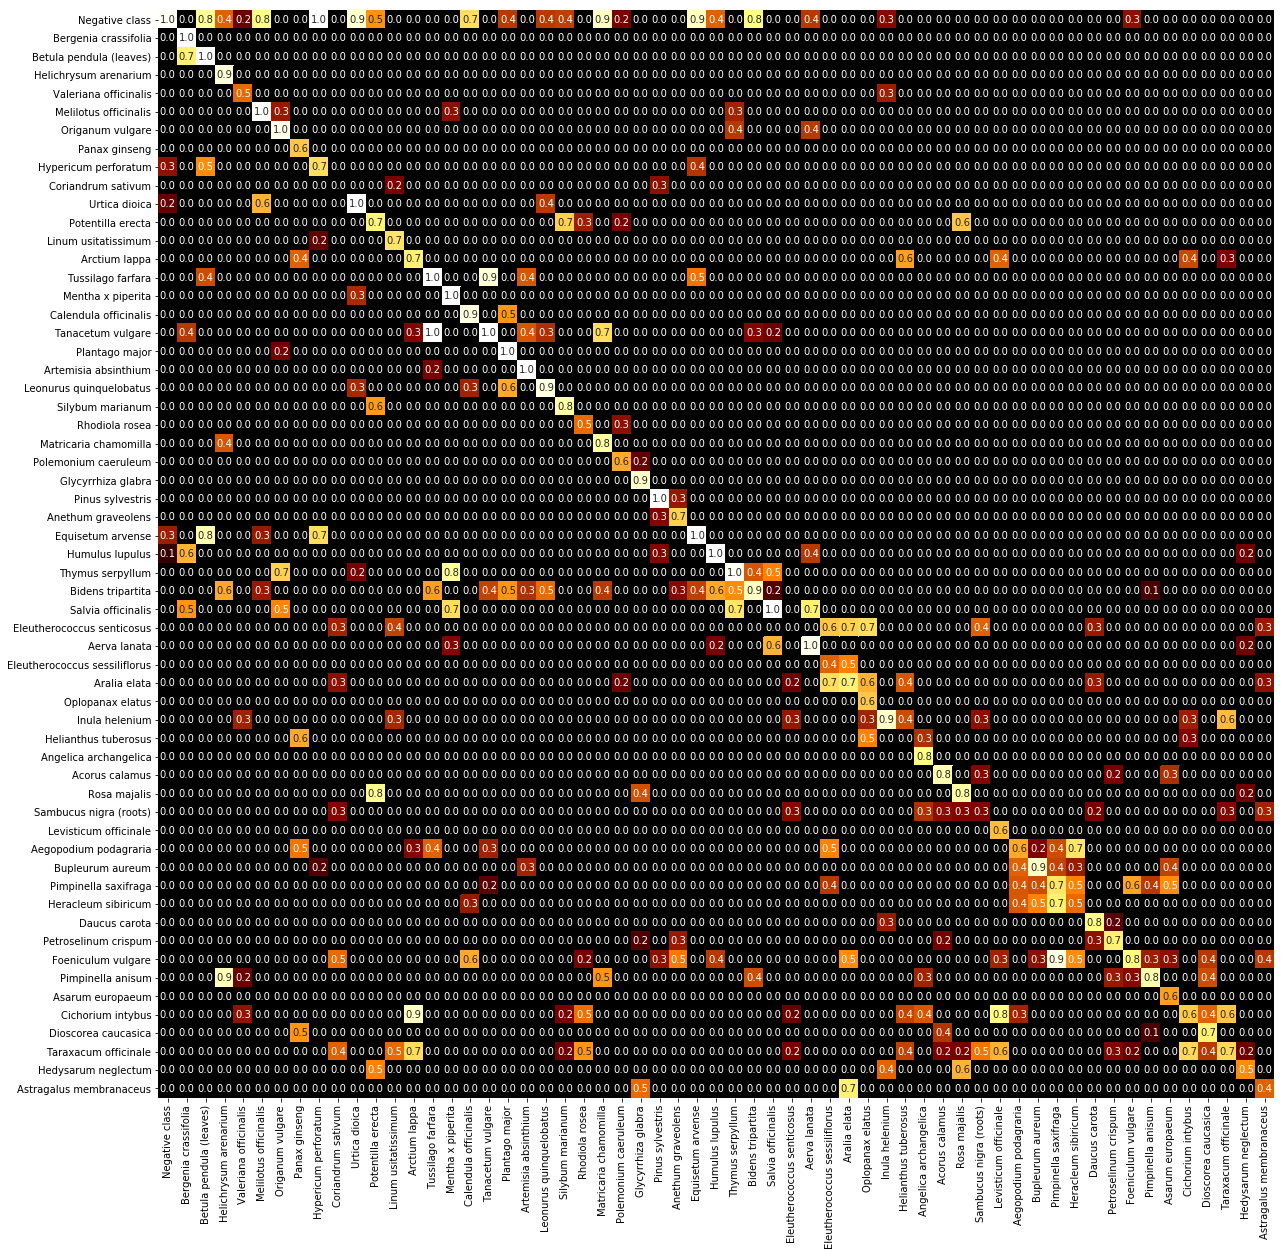

In [12]:
Nclasses = len(classes)
df_mat = np.zeros([Nclasses, Nclasses])
for i_act in xrange(Nclasses):
    current_class = classes[i_act]
    current_top = final_tops_test1[current_class]
    for (pred_class, freq) in current_top:
        j_pred = np.where(classes == pred_class)[0]
        df_mat[j_pred, i_act] = freq
filename = 'snmf_top5'
df_labels = map(lambda x: label_plant_dict[x], classes)
savePlotedCustomConfusionMatrix(
        df_mat, df_labels, filename, figsize=(20, 20),
        extension='pdf', show=True
)

## Sparse NTD

In [13]:
df_nb = np.load('../results/rankMZ=25model_td_+CCA.npz')
prediction_matrices_test1 = df_nb['predicted_pa_test']
prediction_matrices_test2 = df_nb['predicted_pa_test2']
classes = np.unique(prediction_matrices_test1[0][:, -1]) # it contains all necessary classes

N = 5
accuracies_test1, final_tops_test1 = getAccuracyTopN(prediction_matrices_test1, classes, N)
accuracies_test1 = ['test1'] + list(accuracies_test1)
accuracies_test2 = getAccuracyTopN(prediction_matrices_test2, classes, N, only_accuracies=True)
accuracies_test2 = ['test2'] + list(accuracies_test2)
accuracies = [accuracies_test1, accuracies_test2]
df = pd.DataFrame(accuracies, columns=['part']+['top %d' % (i+1) for i in xrange(N)])
df.set_index('part', inplace=True)
print 'accuracy (SNTD) top %d' % (N)
df

accuracy (SNTD) top 5


,top 1,top 2,top 3,top 4,top 5
part,,,,,
test1,0.785047,0.827586,0.850467,0.857143,0.870130
test2,0.840909,0.886364,0.909091,0.909091,0.931818


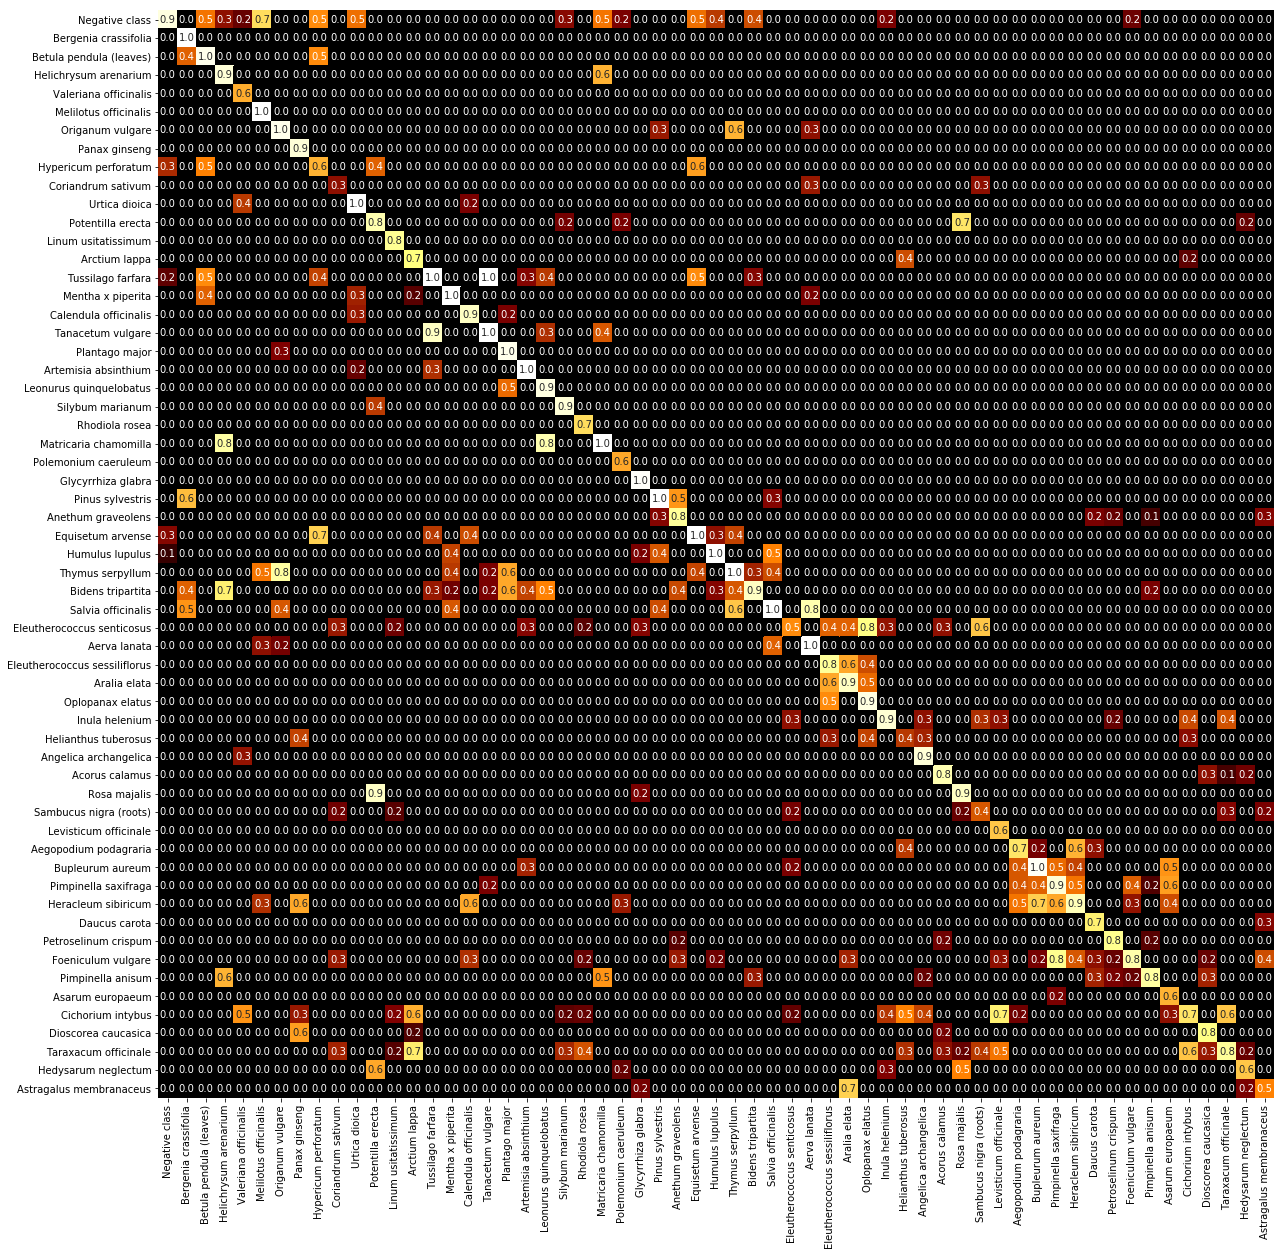

In [15]:
Nclasses = len(classes)
df_mat = np.zeros([Nclasses, Nclasses])
for i_act in xrange(Nclasses):
    current_class = classes[i_act]
    current_top = final_tops_test1[current_class]
    for (pred_class, freq) in current_top:
        j_pred = np.where(classes == pred_class)[0]
        df_mat[j_pred, i_act] = freq
filename = 'sntd_top5'
df_labels = map(lambda x: label_plant_dict[x], classes)
savePlotedCustomConfusionMatrix(
        df_mat, df_labels, filename, figsize=(20, 20),
        extension='pdf', show=True
)